# 데이터 스케일링

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('D:\Machine Learning\ADP-master\data/bikeshare.csv')

# type별로 컬럼 분류
col_id = []
col_dt = ['datetime']
col_cat = ['season']
col_int = ['weather', 'humidity','casual','registered','count']
col_float = ['temp','atemp','windspeed']
col_bool = ['holiday','workingday']

col_num = col_int + col_float
data['datetime'] = pd.to_datetime(data['datetime'])
data[col_cat]= data[col_cat].astype('str')
data[col_int] = data[col_int].astype('int', errors='ignore')
data[col_float] = data[col_float].astype('float')

data.head()
X_data=data[['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']]
Y_data=data[['count']]                                 # 참고 : X_data=DF.drop(['종속변수'].axis=1, inplace=False)

In [2]:
X_data.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,0,0,1,9.84,14.395,81,0.0,3,13
1,0,0,1,9.02,13.635,80,0.0,8,32
2,0,0,1,9.02,13.635,80,0.0,5,27
3,0,0,1,9.84,14.395,75,0.0,3,10
4,0,0,1,9.84,14.395,75,0.0,0,1


In [3]:
Y_data.head()

,count
0,16
1,40
2,32
3,13
4,1


# 정규화, 표준화

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method=='Standard':
        scaled_data=StandardScaler().fit_transform(input_data)
    elif method== 'MinMax':
        scaled_data=MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data=np.log1p(input_data)
    else:
        scaled_data=input_data
    if p_degree != None :
        scaled_data=PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    return scaled_data

# 차원 축소

## Feature Selection
 - Filter-based-method : information grain, chi-square test, fisher score, correlation coefficient, variance threshold
 - Wrapper-based-method : Forward seleciotn, Backward elimination, Recursive feature elimination, Stepwise selection
 - Embeded method : Lasso, Ridge
 
## Feature Extraction
 - Linear method : PCA, LCA
 - Non-Linear method : AE, t-SNE

## Variance Threshold, Chi-squared based feature selection, Select From Model

In [5]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression #SelectFromModel을 위해
from sklearn.ensemble import RandomForestClassifier #SelectFromModel을 위해

lr=LogisticRegression(penalty='l2', C=0.05)
lr.fit(X_data, Y_data)
rf=RandomForestClassifier(n_estimators=20, max_features='auto')
rf.fit(X_data, Y_data)

selector_Var=VarianceThreshold(threshold=0.2)  #VarianceThreshold     ex) threshold=0 : 모든 값이 같은 변수가 제거
selector_Chi=SelectKBest(chi2, k=5) #Chi-squared based feature selection  (5개변수만 선정)
selector_lr=SelectFromModel(estimator=lr, threshold=0.00001, prefit=True) #SelectFromModel
selector_rf=SelectFromModel(estimator=rf, threshold=0.1, prefit=True)

X_reduced_Var=selector_Var.fit_transform(X_data) #Var, KB는 fit_transform
X_reduced_Chi=selector_Chi.fit_transform(X_data, Y_data)
X_reduced_lr=selector_lr.transform(X_data) #SelectFromModel은 fit한 모델로 selector를 만들었기 때문에 transform만 함
X_reduced_rf=selector_rf.transform(X_data)


print('X_data: {0}, X_reduced_Var: {1}, X_reduced_KB:{2}'.format(X_data.shape, X_reduced_Var.shape,  X_reduced_Chi.shape))
print('X_reduced_lr: {0}, X_reduced_rf: {1}'.format(X_reduced_lr.shape,  X_reduced_rf.shape))

print('#### X_data ##### \n', X_data.head(2)) #type(X_data) : DataFrame
print('#### X_reduced_Var #### \n', X_reduced_Var[0:2, :]) #type(X_reduced) : ndarray
print('#### X_reduced_Chi #### \n', X_reduced_Chi[0:2, :]) 
print('selector_Chi.scores_: \n', selector_Chi.scores_)
print('selector_Chi.pvalues_ : \n',selector_Chi.pvalues_)
print('#### X_reduced_lr #### \n', X_reduced_lr[0:2, :]) 
print('#### X_reduced_rf #### \n', X_reduced_rf[0:2, :]) 

X_data: (10886, 9), X_reduced_Var: (10886, 8), X_reduced_KB:(10886, 5)
X_reduced_lr: (10886, 9), X_reduced_rf: (10886, 6)
#### X_data ##### 
    holiday  workingday  weather  temp   atemp  humidity  windspeed  casual  \
0        0           0        1  9.84  14.395        81        0.0       3   
1        0           0        1  9.02  13.635        80        0.0       8   

   registered  
0          13  
1          32  
#### X_reduced_Var #### 
 [[ 0.     1.     9.84  14.395 81.     0.     3.    13.   ]
 [ 0.     1.     9.02  13.635 80.     0.     8.    32.   ]]
#### X_reduced_Chi #### 
 [[ 9.84  14.395 81.     3.    13.   ]
 [ 9.02  13.635 80.     8.    32.   ]]
selector_Chi.scores_: 
 [6.81355480e+02 3.20135759e+02 2.34265530e+02 8.17418862e+03
 8.15250147e+03 1.22860675e+04 5.28275691e+03 4.62518232e+05
 1.52880232e+06]
selector_Chi.pvalues_ : 
 [0.99986728 1.         1.         0.         0.         0.
 0.         0.         0.        ]
#### X_reduced_lr #### 
 [[ 0.     0.     1.

###### Recursive feature elimination (RFE)

In [6]:
from sklearn.feature_selection import RFECV
from sklearn import svm #서포트벡터머신
from sklearn.model_selection import StratifiedKFold

In [ ]:
svc=svm.SVC(kernel='linear')
rfecv=RFECV(estimator=svc, step=1, cv=StratifiedKFold(n_splits=2), scoring='accuracy', verbose=1)
rfecv.fit(X_data, Y_data)
print(rfecv.n_features_)
print(rfecv.support_)

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.


## Ridge, Lasso, ElasticNet

In [7]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

def get_linear_reg_eval (model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df=pd.DataFrame()
    if verbose:
        print('####', model_name, '####')
    for param in params:
        if model_name=='Ridge':
            model=Ridge(alpha=param)
        elif model_name=='Lasso':
            model=Lasso(alpha=param)
        elif model_name=='ElasticNet':
            model=ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores=cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha{0}일 때 5folds의 평균 rmse: {1:.3f}'.format(param, avg_rmse))
        model.fit(X_data, Y_data)
        coeff=pd.Series(data=model.coef_[0], index=X_data.columns)
        colname='alpha:'+str(param)
        coeff_df[colname]=coeff
    return coeff_df

In [8]:
ridge_alphas=[0, 0.1, 1, 10, 100]
lasso_alphas=[0.07, 0.1, 0.5, 1.3]
elastic_alphas=[0.07, 0.1, 0.5, 1.3]

coeff_ridge_df=get_linear_reg_eval('Ridge', params=ridge_alphas, X_data_n=X_data, y_target_n=Y_data)
coeff_lasso_df=get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=Y_data)
coeff_elastic_df=get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=Y_data)

sort_column_ridge='alpha:'+str(ridge_alphas[0])
sort_column_lasso='alpha:'+str(lasso_alphas[0])
sort_column_elastic='alpha:'+str(elastic_alphas[0])

coeff_ridge_df.sort_values(by=sort_column_ridge, ascending=False)
coeff_lasso_df.sort_values(by=sort_column_lasso, ascending=False)
coeff_elastic_df.sort_values(by=sort_column_elastic, ascending=False)

print('##### Ridge ##### \n', coeff_ridge_df)
print('##### Lasso ##### \n',coeff_lasso_df)
print('##### ElasticNet ##### \n',coeff_elastic_df)

#### Ridge ####
alpha0일 때 5folds의 평균 rmse: 0.000
alpha0.1일 때 5folds의 평균 rmse: 0.000
alpha1일 때 5folds의 평균 rmse: 0.000
alpha10일 때 5folds의 평균 rmse: 0.000
alpha100일 때 5folds의 평균 rmse: 0.000
#### Lasso ####
alpha0.07일 때 5folds의 평균 rmse: 0.002
alpha0.1일 때 5folds의 평균 rmse: 0.002
alpha0.5일 때 5folds의 평균 rmse: 0.011
alpha1.3일 때 5folds의 평균 rmse: 0.029
#### ElasticNet ####
alpha0.07일 때 5folds의 평균 rmse: 0.002
alpha0.1일 때 5folds의 평균 rmse: 0.002
alpha0.5일 때 5folds의 평균 rmse: 0.011
alpha1.3일 때 5folds의 평균 rmse: 0.028
##### Ridge ##### 
                  alpha:0     alpha:0.1       alpha:1      alpha:10  \
holiday     4.197878e-14 -9.121727e-08 -9.083481e-07 -8.714585e-06   
workingday  2.532443e-13 -2.809856e-07 -2.808038e-06 -2.790063e-05   
weather    -3.542129e-13  2.223220e-08  2.222049e-07  2.210106e-06   
temp        6.502524e-14  9.496911e-09  9.492827e-08  9.452952e-07   
atemp      -7.350914e-14  8.681085e-09  8.682914e-08  8.700409e-07   
humidity    1.682264e-14 -5.620571e-09 -5.619923e-08 -5

## PCA, LDA, Truncated SVD, NMF

In [9]:
data.loc[data['count'] <= 150, 'y1'] = 0
data.loc[(data['count']>150)&(data['count'] <= 300), 'y1'] = 1
data.loc[(data['count']>300)&(data['count'] <= 450), 'y1'] = 2
data.loc[data['count'] > 450, 'y1'] = 3
Data=data[['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'y1']]
x_data=Data.drop(['y1'], axis=1, inplace=False)
y_data=Data['y1']

#data_scaled=StandardScaler().fit_transform(Data)      *x_data를 정규화     *정규화 데이터는 모두 float 형태로 구성되어야 함
scaled_data=get_scaled_data(method='Standard', p_degree=None, input_data=x_data)

from sklearn.ensemble import RandomForestClassifier #분류 모델 호출
from sklearn.model_selection import cross_val_score
rcf=RandomForestClassifier(random_state=156) 

In [10]:
from sklearn.decomposition import PCA, TruncatedSVD, NMF #PCA, Truncated SVD, NMF(non-Negative Matrix Factorization)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA 선형판별분석  *분류에 유리 *스케일링 필요


pca=PCA(n_components=3)
lda=LinearDiscriminantAnalysis(n_components=2)
tsvd=TruncatedSVD(n_components=2)
nmf=NMF(n_components=2)


pca.fit(scaled_data)
lda.fit(scaled_data, y_data) #LDA는 선형판별분석이므로 y_data 들어가는 것에 유의
tsvd.fit(scaled_data)
nmf.fit(X_data) #NMF는 데이터에 음수값이 없어야함

data_pca=pca.transform(scaled_data)
data_lda=lda.transform(scaled_data)
data_tsvd=tsvd.transform(scaled_data)
data_nmf=nmf.transform(X_data)

pca_columns=['pca_component_1', 'pca_component_2', 'pca_component_3']
lda_columns=['lda_component_1', 'lda_component_2']
tsvd_columns=['tsvd_component_1', 'tsvd_component_2']
nmf_columns=['nmf_component_1', 'nmf_component_2']

data_pca=pd.DataFrame(data_pca, columns=pca_columns)
data_lda=pd.DataFrame(data_lda, columns=lda_columns)
data_tsvd=pd.DataFrame(data_tsvd, columns=tsvd_columns)
data_nmf=pd.DataFrame(data_nmf, columns=nmf_columns)

data_pca['target']=y_data
data_lda['target']=y_data
data_tsvd['target']=y_data
data_nmf['target']=y_data

print('#### PCA #### \n', data_pca.head(-10))
print('#### LDA #### \n', data_lda.head(-10))
print('#### TSVD #### \n', data_tsvd.head(-10))
print('#### NMF #### \n', data_nmf.head(-10))

pca_X=data_pca[['pca_component_1', 'pca_component_2']]
lda_X=data_lda[['lda_component_1', 'lda_component_2']]
tsvd_X=data_tsvd[['tsvd_component_1', 'tsvd_component_2']]
nmf_X=data_nmf[['nmf_component_1', 'nmf_component_2']]


scores=cross_val_score(rcf, scaled_data, y_data, scoring='accuracy', cv=3)
scores_pca=cross_val_score(rcf, pca_X, data_pca['target'], scoring='accuracy', cv=3)
scores_lda=cross_val_score(rcf, lda_X, data_lda['target'], scoring='accuracy', cv=3)
scores_tsvd=cross_val_score(rcf, tsvd_X, data_tsvd['target'], scoring='accuracy', cv=3)
scores_nmf=cross_val_score(rcf, nmf_X, data_nmf['target'], scoring='accuracy', cv=3)

print('Original Score:', scores)
print('PCA Score: ', scores_pca)
print('LDA Score: ', scores_lda)
print('TSVD Score:', scores_tsvd)
print('NMF Score:', scores_nmf)

#### PCA #### 
        pca_component_1  pca_component_2  pca_component_3  target
0            -2.108688        -0.172691         1.357184     0.0
1            -2.100988        -0.043042         1.355272     0.0
2            -2.142273        -0.055844         1.347885     0.0
3            -2.040526         0.010907         1.318252     0.0
4            -2.091981        -0.005314         1.315689     0.0
...                ...              ...              ...     ...
10871        -1.170139         0.308125        -0.700675     2.0
10872        -1.185861         0.182133        -0.514291     1.0
10873        -0.278014         0.836951        -0.739946     1.0
10874        -0.138796         1.073860        -0.833524     1.0
10875        -0.117747         0.800987        -0.764572     1.0

[10876 rows x 4 columns]
#### LDA #### 
        lda_component_1  lda_component_2  target
0            -3.145626         1.553908     0.0
1            -2.708872         1.657926     0.0
2            -2.86

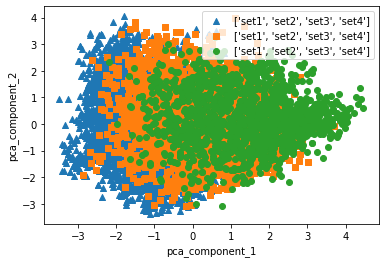

[0.29798885 0.17516513 0.14809569]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

markers=['^', 's', 'o']
for i, marker in enumerate (markers):
    x_axis_data=data_pca[data_pca['target']==i]['pca_component_1']
    y_axis_data=data_pca[data_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=['set1', 'set2', 'set3', 'set4'])

plt.legend()
plt.xlabel('pca_component_1') ; plt.ylabel('pca_component_2')
plt.show()
print(pca.explained_variance_ratio_)

Text(0, 0.5, 'TruncatedSVD Component2')

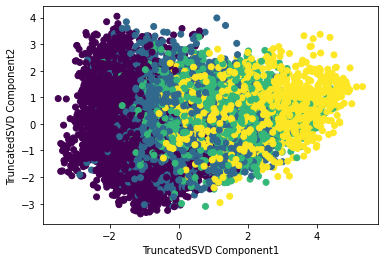

In [12]:
plt.scatter(x=data_tsvd['tsvd_component_1'], y=data_tsvd['tsvd_component_2'], c=data_tsvd['target'])
plt.xlabel('TruncatedSVD Component1'); plt.ylabel('TruncatedSVD Component2')

# 오버샘플링/언더샘플링

 - 빅데이터분석기사 실기 시험 지원 패키지에 imblearn 없음 (고로 시험에 안나옴)